#Noise

Pošto je skup podataka mali, neke augmentacije mogu da se vrše nad slikama kako bi se veštački postigao veći broj uzoraka. Na taj način sprečavamo model da "nauči napamet" neke karakteristike, već mora da generalizuje.

Rotacija i refleksija kao metod augmentacije podataka nažalost ne dolaze u obzir. Neke stvari zavise od položaja (levo plućno krijo je manje) i pretpostavka je da svi uvek stoje uspravno kada se slikaju za rendgen (i najmanja rotacija može poremetiti odnose, možda moraju da se porede dva krila na neki način da bi se dobio neki zaključak).

Uvođenje šuma međutim ima više smisla. Slike mogu biti malo mutnije, i nije svaki piksel važan, već su važni neki rasponi vrednosti.

Ovaj dokument će videti kako uvođenje šuma utiče na moć generalizacije malopre napravljenog malog modela.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import os
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
data_dir = "/content/drive/MyDrive/MasinskoUcenjeChestXRay/resources/scaled"

In [3]:
def load_images_to_numpy(src_path: str) -> np.ndarray:
    res = os.listdir(src_path)
    res = map(lambda path: os.path.join(src_path, path), res)
    res = map(Image.open, res)
    res = map(np.asarray, res)
    res = np.stack([*res], axis=0)
    return res

def load_images(src_path: str):
    X_false = load_images_to_numpy(os.path.join(src_path, "NORMAL"))
    y_false = np.zeros((X_false.shape[0],), dtype=np.uint8)

    X_true = load_images_to_numpy(os.path.join(src_path, "PNEUMONIA"))
    y_true = np.ones((X_true.shape[0],), dtype=np.uint8)

    X = np.concatenate([X_false, X_true])
    y = np.concatenate([y_false, y_true])
    return (X, y)

In [4]:
X, y = load_images(os.path.join(data_dir, "train"))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

Šum možemo uvoditi tako što ulazni vektor saberemo sa matricom šumova nastalim iz normalne raspodele sa očekivanjem 0. U narednom primeru iskoristićemo tri različita parametra za standardnu devijaciju šuma, i videti koliko jačina šuma utiče na performanse modela i da li utiče uopšte.

Klasa `GaussianNoise` uvodi šum samo pri treniranju, prilikom predviđanja se ne aktivire, tako da će `predict` metod biti pozvan na neaugmentovanim podacima.

In [6]:
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

In [7]:
def make_model(shape, activation, noise, **kwargs):
    model = Sequential()

    model.add(InputLayer(shape))
    model.add(Rescaling(scale=1/255))
    model.add(GaussianNoise(noise))
    model.add(Reshape((shape[0], shape[1], 1)))

    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation=activation))
    model.compile(**kwargs)
    return model

In [10]:
models = [
    make_model(
      shape=(X_train.shape[1], X_train.shape[2]),
      activation='sigmoid',
      noise=noise/255,
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['accuracy']
    )
    for noise in [1,2,3]
]

In [11]:
models[0].summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 280, 400)          0         
                                                                 
 gaussian_noise_1 (GaussianN  (None, 280, 400)         0         
 oise)                                                           
                                                                 
 reshape_1 (Reshape)         (None, 280, 400, 1)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 278, 398, 16)      160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 139, 199, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 137, 197, 32)     

In [12]:
model_path = "/content/drive/MyDrive/MasinskoUcenjeChestXRay/models/noise"
if not os.path.isdir(model_path):
        os.makedirs(model_path)
model_checkpoints_path = os.path.join(model_path, "checkpoint")
if not os.path.isdir(model_checkpoints_path):
        os.makedirs(model_checkpoints_path)

In [13]:
histories = [
    model.fit(
        X_train, y_train,
        verbose=0,
        epochs=50,
        validation_split=0.1,
        callbacks=[
            ModelCheckpoint(
              filepath=os.path.join(model_checkpoints_path, f"{i+1}" + "-{epoch:02d}.h5"),
              save_best_only=True,
              monitor='val_loss',
              mode='min'
            )
        ]
    )
    for i, model in enumerate(models)
]

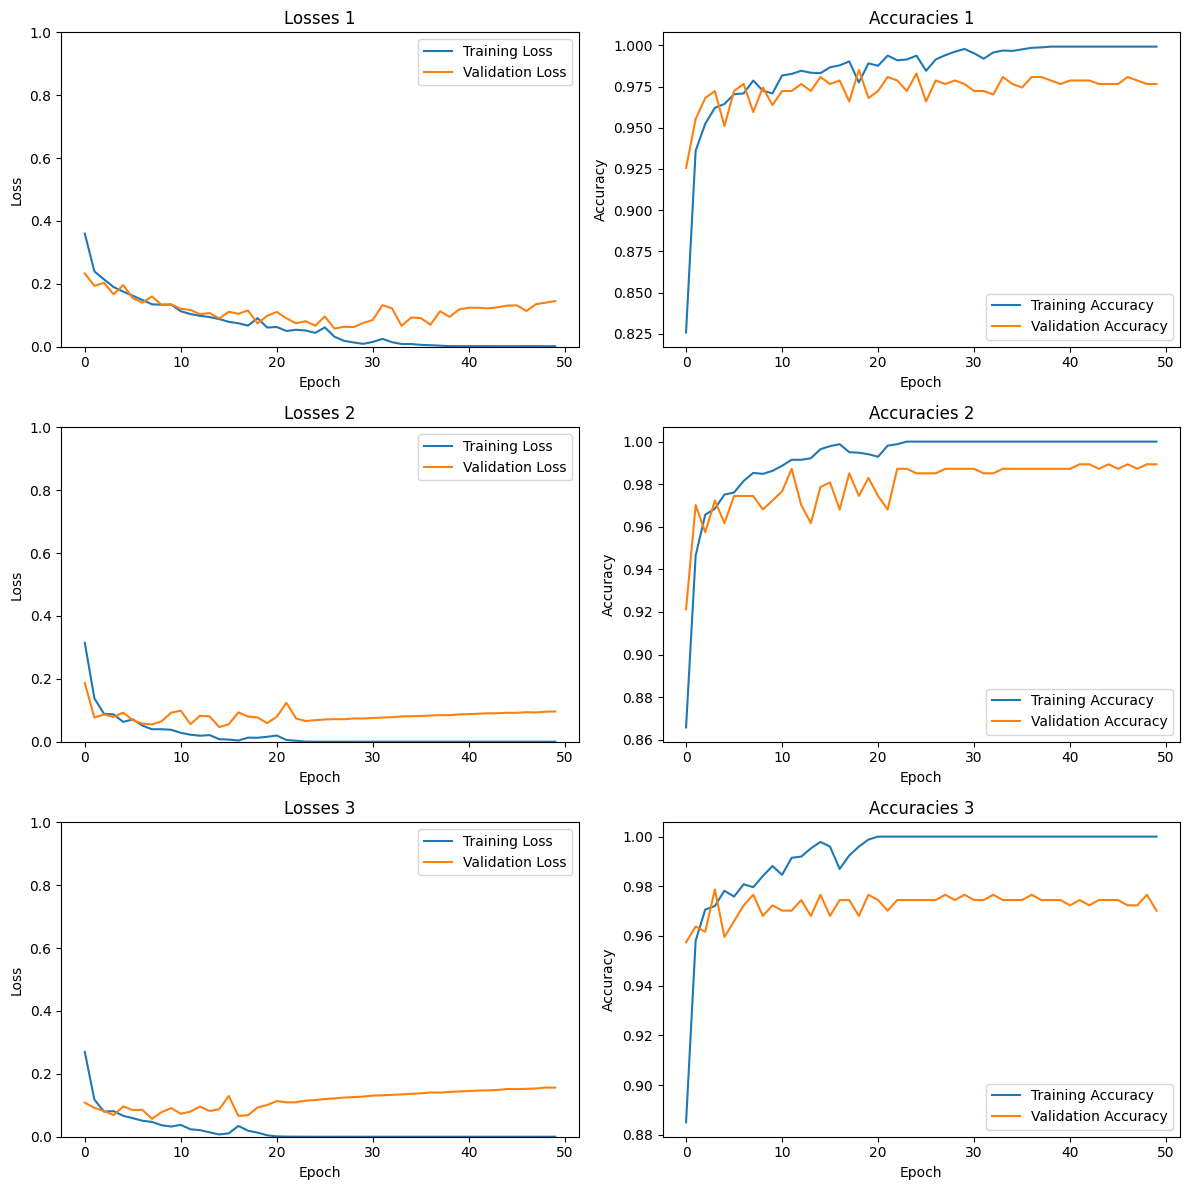

In [23]:
plt.figure(figsize=(12, 12))

for i, history in enumerate(histories):
    plt.subplot(3, 2, i*2 + 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Losses {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0, 1)
    plt.legend()

    plt.subplot(3, 2, i*2 + 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracies {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()

In [24]:
best_models = [
    load_model(os.path.join(model_checkpoints_path, name))
    for name in ["1-27.h5", "2-15.h5", "3-08.h5"]
]

In [25]:
y_preds = [
    np.where(best_model.predict(X_test) < 0.5, 0, 1)
    for best_model in best_models
]

17/17 [==============================] - 0s 10ms/step


In [28]:
for i, y_pred in enumerate(y_preds):
    print(f"Rezultat za model sa sumom {i+1}/255:\n")
    print(classification_report(y_test, y_pred))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=["NORMAL", "PNEUMONIA"], columns=["NORMAL", "PNEUMONIA"]))
    print("="*20)

Rezultat za model sa sumom 1/255:

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       134
           1       0.98      0.99      0.99       388

    accuracy                           0.98       522
   macro avg       0.97      0.97      0.97       522
weighted avg       0.98      0.98      0.98       522

           NORMAL  PNEUMONIA
NORMAL        128          6
PNEUMONIA       5        383
Rezultat za model sa sumom 2/255:

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       134
           1       0.98      0.99      0.99       388

    accuracy                           0.98       522
   macro avg       0.97      0.97      0.97       522
weighted avg       0.98      0.98      0.98       522

           NORMAL  PNEUMONIA
NORMAL        128          6
PNEUMONIA       5        383
Rezultat za model sa sumom 3/255:

              precision    recall  f1-score   support

           0

Prva dva modela se ne razlikuju uopšte, dok treći ima malo slabije performanse. Ovo u poređenju sa grafovima koji su gore nacrtani (nakojima se vidi da je treći model počeo da se stabilizuje i konvergira pri treniranju) sugeriše da je njegiv šum bio previše veliki i uvelo je veliku nestabilnost.

Modeli sa slabijim šumom ne samo da su iskoristili manju arhitekturu, već su postigli performance prvog modela sa velikim brojem parametara. Da se zaključiti da šum doprinosi generalizaciji.

In [29]:
best_models[0].save(os.path.join(model_path, "model.h5"))